### Execute EDA e preveja as vendas dos próximos 7 dias a partir da última data do conjunto de dados de treinamento!

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import warnings
from statsmodels.tsa.ar_model import AutoReg as AR
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
caminho = r'C:\Users\bruno.freitas\Documents\Fundamentos de séries temporais\archive\train.csv'

In [3]:
df = pd.read_csv(caminho, sep=',', encoding='utf-8')

In [4]:
df.dtypes

Row ID             int64
Order ID          object
Order Date        object
Ship Date         object
Ship Mode         object
Customer ID       object
Customer Name     object
Segment           object
Country           object
City              object
State             object
Postal Code      float64
Region            object
Product ID        object
Category          object
Sub-Category      object
Product Name      object
Sales            float64
dtype: object

In [5]:
df.describe()

,Row ID,Postal Code,Sales
count,9800.000000,9789.000000,9800.000000
mean,4900.500000,55273.322403,230.769059
std,2829.160653,32041.223413,626.651875
min,1.000000,1040.000000,0.444000
25%,2450.750000,23223.000000,17.248000
50%,4900.500000,58103.000000,54.490000
75%,7350.250000,90008.000000,210.605000
max,9800.000000,99301.000000,22638.480000


### 1. Análise de consistência e pré-processamento

* Verificar valores ausentes (isnull().sum()).

In [6]:
df.isnull().sum()

Row ID            0
Order ID          0
Order Date        0
Ship Date         0
Ship Mode         0
Customer ID       0
Customer Name     0
Segment           0
Country           0
City              0
State             0
Postal Code      11
Region            0
Product ID        0
Category          0
Sub-Category      0
Product Name      0
Sales             0
dtype: int64

* Verificar tipos de dados (especialmente Ship Date, que está como object e deveria ser datetime).

In [7]:
df['Ship Date'] = pd.to_datetime(df['Ship Date'], dayfirst=True)

* Conferir duplicatas (duplicated()).

In [8]:
df.duplicated().sum()

np.int64(0)

### 2. Análise temporal

* Quantidade de registros por data:

<Axes: xlabel='Order Date'>

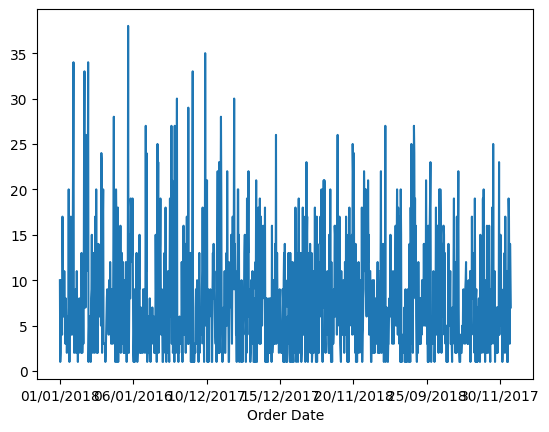

In [9]:
df['Order Date'].value_counts().sort_index().plot()

* Agregar as vendas por data:

In [10]:
df_daily = df.groupby('Order Date')['Sales'].sum().reset_index()


* Visualizar a série:

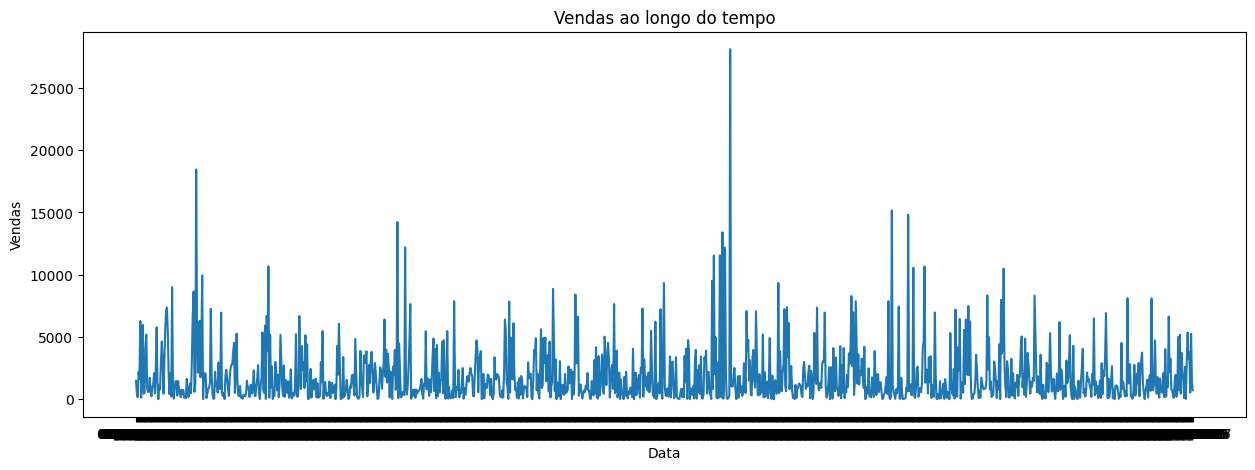

In [11]:
plt.figure(figsize=(15,5))
plt.plot(df_daily['Order Date'], df_daily['Sales'])
plt.title('Vendas ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.show()


### 3. Análise de tendências e sazonalidade

* Verificar se há tendência crescente, decrescente ou ciclos.

Text(0.5, 1.0, 'Média móvel de 30 dias das vendas')

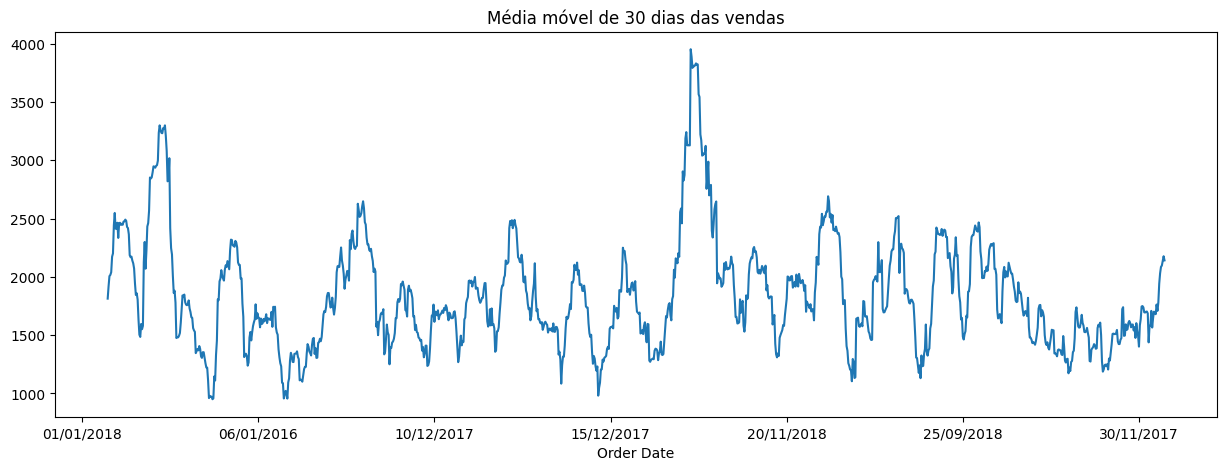

In [12]:
df_daily.set_index('Order Date')['Sales'].rolling(window=30).mean().plot(figsize=(15,5))
plt.title('Média móvel de 30 dias das vendas')


* Decompor a série:

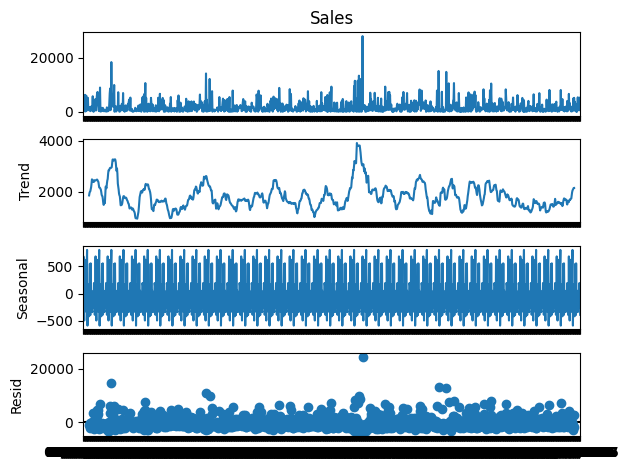

In [ ]:
result = seasonal_decompose(df_daily.set_index('Order Date')['Sales'], model='additive', period=30)
result.plot()
plt.show()


### 4. Análise de autocorrelação


* Verificar dependência temporal, importante para modelos como ARIMA.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

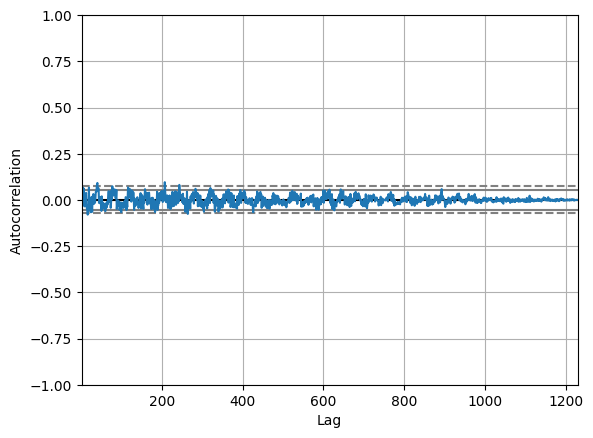

In [16]:
autocorrelation_plot(df_daily.set_index('Order Date')['Sales'])


### 5. Análise de anomalias


* Detectar picos ou quedas fora do padrão.


* Visualização simples:

Text(0.5, 1.0, 'Detecção visual de anomalias nas vendas')

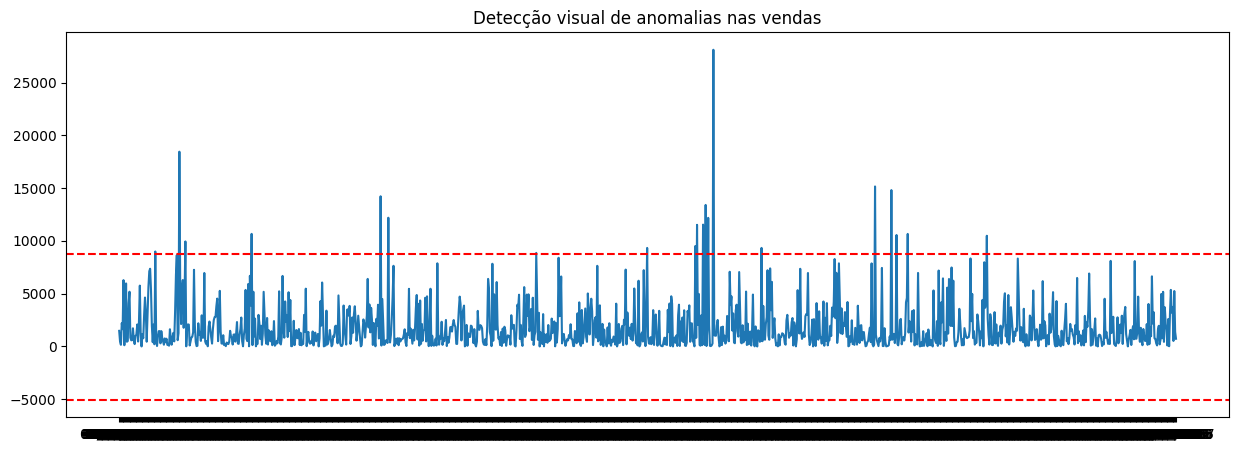

In [17]:
plt.figure(figsize=(15,5))
plt.plot(df_daily['Order Date'], df_daily['Sales'])
plt.axhline(df_daily['Sales'].mean() + 3*df_daily['Sales'].std(), color='r', linestyle='--')
plt.axhline(df_daily['Sales'].mean() - 3*df_daily['Sales'].std(), color='r', linestyle='--')
plt.title('Detecção visual de anomalias nas vendas')


### 6. Análise por categorias (opcional, mas muito útil)



* Verificar se há sazonalidade ou comportamento diferente por:

    * Região (Region)

    * Categoria (Category)

    * Sub-Categoria (Sub-Category)

    * Segmento (Segment)

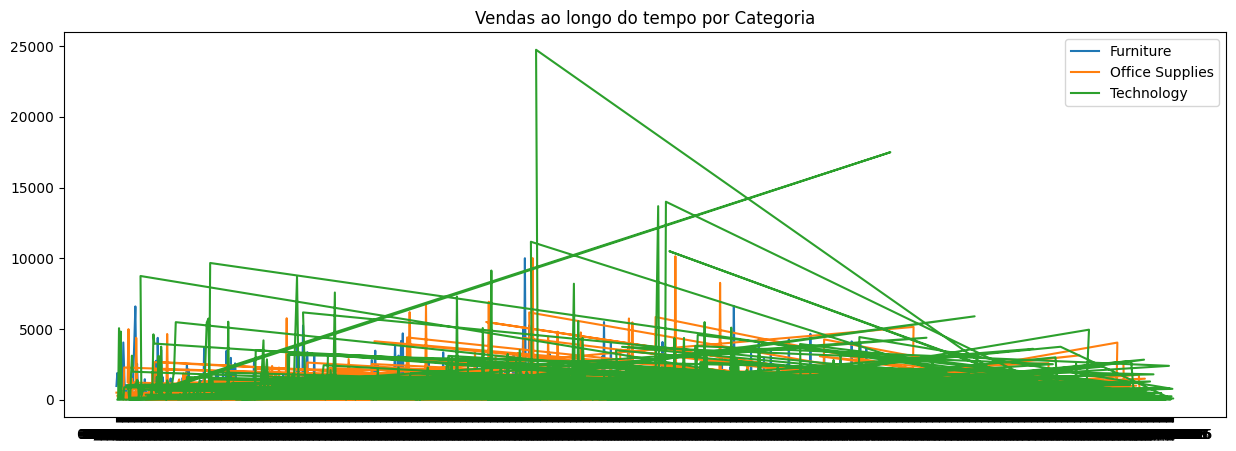

In [18]:
df_group = df.groupby(['Order Date', 'Category'])['Sales'].sum().reset_index()

plt.figure(figsize=(15,5))
for category in df_group['Category'].unique():
    temp = df_group[df_group['Category'] == category]
    plt.plot(temp['Order Date'], temp['Sales'], label=category)

plt.legend()
plt.title('Vendas ao longo do tempo por Categoria')
plt.show()


### Passo 2: Separação Train-Test-Validação

In [20]:
# Converter datas para garantir o tipo correto
df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True)

# Agregar as vendas por dia (pode ser ajustado para 'M' para mensal ou 'W' para semanal)
serie_perfeita = df.groupby('Order Date')['Sales'].sum().reset_index()

# Definir a data como índice (recomendado para séries temporais)
serie_perfeita = serie_perfeita.set_index('Order Date')

# Se quiser garantir que não falte nenhuma data no intervalo
serie_perfeita = serie_perfeita.asfreq('D')  # D para diário, W para semanal, M para mensal

# Preencher valores ausentes (se houver dias sem vendas)
serie_perfeita['Sales'] = serie_perfeita['Sales'].fillna(0)


In [21]:
train_size = int(0.8 * len(serie_perfeita))
validation_size = int(0.1 * len(serie_perfeita))

train = serie_perfeita[:train_size]
validation = serie_perfeita[train_size:train_size + validation_size]
test = serie_perfeita[train_size + validation_size:]


In [22]:
warnings.filterwarnings("ignore")

# Ranges a testar
p_range = range(0, 6)  # AR terms
d_range = range(0, 3)  # Differencing terms
q_range = range(0, 6)  # MA terms

# Guardar os melhores resultados
best_aic = np.inf
best_order = None
best_model = None

# Loop por combinações
for p in p_range:
    for d in d_range:
        for q in q_range:
            try:
                model = ARIMA(train, order=(p, d, q))
                fitted_model = model.fit()
                aic = fitted_model.aic
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, d, q)
                    best_model = fitted_model
                print(f'Tested ARIMA({p},{d},{q}) - AIC: {aic:.2f}')
            except:
                continue

# Resultado final
print("\n🔍 Melhor modelo encontrado:")
print(f"ARIMA{best_order} com AIC = {best_aic:.2f}")


Tested ARIMA(0,0,0) - AIC: 21152.17
Tested ARIMA(0,0,1) - AIC: 21138.84
Tested ARIMA(0,0,2) - AIC: 21138.07
Tested ARIMA(0,0,3) - AIC: 21132.99
Tested ARIMA(0,0,4) - AIC: 21134.62
Tested ARIMA(0,0,5) - AIC: 21135.37
Tested ARIMA(0,1,0) - AIC: 21790.11
Tested ARIMA(0,1,1) - AIC: 21101.05
Tested ARIMA(0,1,2) - AIC: 21100.10
Tested ARIMA(0,1,3) - AIC: 21102.09
Tested ARIMA(0,1,4) - AIC: 21105.68
Tested ARIMA(0,1,5) - AIC: 21106.96
Tested ARIMA(0,2,0) - AIC: 23026.47
Tested ARIMA(0,2,1) - AIC: 21780.44
Tested ARIMA(0,2,2) - AIC: 21126.06
Tested ARIMA(0,2,3) - AIC: 21096.28
Tested ARIMA(0,2,4) - AIC: 21157.08
Tested ARIMA(0,2,5) - AIC: 21106.70
Tested ARIMA(1,0,0) - AIC: 21137.22
Tested ARIMA(1,0,1) - AIC: 21108.02
Tested ARIMA(1,0,2) - AIC: 21108.87
Tested ARIMA(1,0,3) - AIC: 21110.01
Tested ARIMA(1,0,4) - AIC: 21112.13
Tested ARIMA(1,0,5) - AIC: 21112.81
Tested ARIMA(1,1,0) - AIC: 21501.24
Tested ARIMA(1,1,1) - AIC: 21100.12
Tested ARIMA(1,1,2) - AIC: 21103.92
Tested ARIMA(1,1,3) - AIC: 2

### Passo 3: Teste Estacionariedade

In [ ]:
# test adfuller
adf_test = adfuller( train )

# Exibir os resultados do teste
print("Resultado do Teste de Dickey-Fuller:")
print(f"Estatística ADF: {adf_test[0]:.4f}")
print(f"Valor-p: {adf_test[1]:.4f}")

# Interpretação do teste
if adf_test[1] > 0.05:
 print("\nA série NÃO é estacionária (não rejeitamos H0).")
else:
 print("\nA série é estacionária (rejeitamos H0).")

### Passo 5: Teste PACF e ACF

In [ ]:
serie_diferenciada = train.copy()
# teste PACF
plt.figure( figsize=(12, 6) )
plot_pacf( serie_diferenciada, lags=20 );
# teste ACF
plot_acf( serie_diferenciada, lags=20 );

In [ ]:
plt.figure(figsize=(12,6))
plot_pacf(train, lags=20)
plt.title('PACF - Para determinar p')
plt.show()

plt.figure(figsize=(12,6))
plot_acf(train, lags=20)
plt.title('ACF - Para determinar q')
plt.show()

In [23]:
# parametros
p, d, q = best_order

In [24]:
predictions = []
actuals = []
train_series = train.copy()

In [29]:
p_values = [5, 6, 7]
q_values = [2, 3]
d_values = [1]

# Adiciona o melhor encontrado
p_values.append(best_order[0])
d_values.append(best_order[1])
q_values.append(best_order[2])

# Remove duplicatas (caso o melhor já esteja na lista)
p_values = list(set(p_values))
d_values = list(set(d_values))
q_values = list(set(q_values))


In [ ]:
# Use only the first 10 indices to match the length of predictions/actuals
df_val = pd.DataFrame(
	{"Predictions": predictions, "Actuals": actuals},
	index=validation.index[:len(predictions)]
)
errors = df_val['Actuals'] - df_val['Predictions']
rmse_val = np.sqrt(np.mean(errors**2))
mae_val = np.mean(np.abs(errors))
mape_val = np.mean(np.abs(errors / df_val['Actuals']))
log_likelihood = model_fit.llf
num_obs = len(train_series)
num_params = model_fit.params.shape[0]
aic_val = -2 * log_likelihood + 2 * num_params
bic_val = -2 * log_likelihood + num_params * np.log(num_obs)

print(f'RMSE: {rmse_val:.2f} | MAE: {mae_val:.2f} | MAPE: {mape_val:.2f}')
print(f'AIC: {aic_val:.2f} | BIC: {bic_val:.2f}')

ValueError: Length of values (10) does not match length of index (145)

In [28]:
from numpy.linalg import LinAlgError

for t in range(len(validation)):
    # Use only the 'Sales' column for ARIMA and drop any NaNs
    sales_series = train_series['Sales'].dropna()
    try:
        model = ARIMA(sales_series, order=(p, d, q))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=1).iloc[0]
        predictions.append(forecast)
        actuals.append(validation.iloc[t])
        # Add new value to 'Sales' column, keeping the DataFrame structure
        train_series.loc[validation.index[t], 'Sales'] = validation.iloc[t, 0]
    except LinAlgError:
        print(f"Skipped step {t} due to LinAlgError.")
        continue


Skipped step 0 due to LinAlgError.
Skipped step 1 due to LinAlgError.
Skipped step 2 due to LinAlgError.
Skipped step 3 due to LinAlgError.
Skipped step 4 due to LinAlgError.
Skipped step 5 due to LinAlgError.
Skipped step 6 due to LinAlgError.
Skipped step 7 due to LinAlgError.
Skipped step 8 due to LinAlgError.
Skipped step 9 due to LinAlgError.
Skipped step 10 due to LinAlgError.
Skipped step 11 due to LinAlgError.
Skipped step 12 due to LinAlgError.
Skipped step 13 due to LinAlgError.
Skipped step 14 due to LinAlgError.
Skipped step 15 due to LinAlgError.
Skipped step 16 due to LinAlgError.
Skipped step 17 due to LinAlgError.
Skipped step 18 due to LinAlgError.
Skipped step 19 due to LinAlgError.
Skipped step 20 due to LinAlgError.
Skipped step 21 due to LinAlgError.
Skipped step 22 due to LinAlgError.
Skipped step 23 due to LinAlgError.
Skipped step 24 due to LinAlgError.
Skipped step 25 due to LinAlgError.
Skipped step 26 due to LinAlgError.
Skipped step 27 due to LinAlgError.
Sk

KeyboardInterrupt: 

In [ ]:
# Fine Tuning
p_values = [5, 6, 7]
q_values = [2, 3]
d_values = [1]
num_iterations = 2
results_val = pd.DataFrame()
for _ in range( num_iterations ):
 p = int( np.random.choice( p_values ) )
 q = int( np.random.choice( q_values ) )
 d = int( np.random.choice( d_values ) )
 print( f'Testando parâmetro: p, d, q={p, d, q}' )
 predictions = []
 actuals = []
 train_series = train.copy()
 for t in range( len( validation ) ):
    # model definition
    model = ARIMA( train_series, order=(p,d,q) )
    # model training
    model_fit = model.fit()
    # forecast
    forecast = model_fit.forecast( steps=1 ).iloc[0]
    # store predictions
    predictions.append( forecast)
    actuals.append( validation.iloc[t])
    # update training
    train_series = pd.concat( [train_series, pd.Series(validation.iloc[t], index=[validation.index[t]])] )
                                                       
 # prediction x actuals
 df_val = pd.DataFrame( {"Predictions": predictions, "Actuals": actuals} )

 # compute metrics
 errors = df_val['Actuals'] - df_val['Predictions']
 rmse_val = np.sqrt( np.mean( errors**2 ) )
 mae_val = np.mean( np.abs( errors ) )
 mape_val = np.mean( np.abs( errors / df_val['Actuals'] ) )
 log_likelihood = model_fit.llf
 num_obs = len( train_series )
 num_params = model_fit.params.shape[0]
 aic_val = -2 * log_likelihood + 2 * num_params
 bic_val = -2 * log_likelihood + num_params * np.log( num_obs )
 # store results
 performance = pd.DataFrame( {"P": p, "D": d, "Q": q,
 "RMSE_VAL": rmse_val ,
 "MAE_VAL": mae_val,
 "MAPE_VAL": mape_val,
 "AIC_VAL": aic_val,
 "BIC_VAL": bic_val } , index=[0] )
 results_val = pd.concat( [results_val, performance] )
results_val.sort_values( "RMSE_VAL", ascending=True )


In [ ]:
# previsao do test
p, d, q = 5, 1, 3
predictions = []
actuals = []
results_test = pd.DataFrame()
train_series = pd.concat( [train, validation] )
for t in range( len( test ) ):
 # model definition
 model = ARIMA( train_series, order=(p,d,q) )

 # model training
 model_fit = model.fit()

 # forecast
 forecast = model_fit.forecast( steps=1 ).iloc[0]

 # store predictions
 predictions.append( forecast )
 actuals.append( test.iloc[t])

 # update training
 train_series = pd.concat( [train_series, pd.Series(test.iloc[t], index=[test.index[t]])] )

# prediction x actuals
df_test = pd.DataFrame( {"Predictions": predictions, "Actuals": actuals } )
df_test.index = test.index

# compute metrics
erros = df_test['Actuals'] - df_test['Predictions']
rmse_test = np.sqrt( np.mean( errors**2 ) )
mae_test = np.mean( np.abs( errors ) )
mape_test = np.mean( np.abs( errors / df_test['Actuals'] ) )
log_likelihood = model_fit.llf
num_obs = len( train_series )
num_params = model_fit.params.shape[0]
aic_test = -2 * log_likelihood + 2 * num_params
bic_test = -2 * log_likelihood + num_params * np.log( num_obs )
performance = pd.DataFrame( {"Q": q, "P": p, "D": d,
 "RMSE_TEST": rmse_test ,
 "MAE_TEST": mae_test,
 "MAPE_TEST": mape_test,
 "AIC_TEST": aic_test,
 "BIC_TEST": bic_test } , index=[0] )
results_test = pd.concat( [results_test, performance] )
results_test

In [ ]:
plt.figure(figsize=(16, 8))
sns.lineplot(x=df_test.index, y=df_test['Predictions'], label='Predictions')
sns.lineplot(x=df_test.index, y=df_test['Actuals'], label='Actuals')
sns.lineplot(x=train.index, y=train, label='Train', color='green')
sns.lineplot(x=validation.index, y=validation, label='Validation', color='orange')

plt.title('Predictions vs Actuals')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()
